# SmallPebble

[![](https://github.com/sradc/smallpebble/workflows/Python%20package/badge.svg)](https://github.com/sradc/smallpebble/commits/) 

**Project status: experimental, unstable.**

<br><p align="center"><img src="pebbles.jpg" /></p><br>

SmallPebble is a minimal/toy automatic differentation/deep learning library written from scratch in Python, using NumPy/CuPy.

The implementation is in [smallpebble.py](https://github.com/sradc/SmallPebble/blob/master/smallpebble/smallpebble.py).

**Features:**
- Relatively simple implementation.
- Powerful API for creating models.
- Various operations, such as matmul, conv2d, maxpool2d.
- Broadcasting support.
- Eager or lazy execution.
- It's easy to add new SmallPebble functions.
- GPU, if use CuPy.

Graphs are built implicitely via Python objects referencing Python objects.
The only real step taken towards improving performance is to use NumPy/CuPy. 

**Should I use this?**

You probably want a more efficient and featureful framework, such as JAX, PyTorch, TensorFlow, etc.

**Read on to see:**
- Examples of deep learning models created and trained using SmallPebble.
- A brief guide to using SmallPebble.

For an introduction to autodiff and an even more minimal autodiff implementation, look [here](https://sidsite.com/posts/autodiff/).

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import smallpebble as sp
from smallpebble.misc import load_data
from tqdm import tqdm

## Training a neural network on MNIST

Load the dataset, and create a validation set.

In [2]:
X_train, y_train, _, _ = load_data('mnist')  # load / download from openml.org
X_train = X_train/255

# Seperate out data for validation.
X = X_train[:50_000, ...]
y = y_train[:50_000]
X_eval = X_train[50_000:60_000, ...]
y_eval = y_train[50_000:60_000]

Build a model.

In [3]:
X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = sp.linearlayer(28*28, 100)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 100)(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 10)(h)
y_pred = sp.Lazy(sp.softmax)(h)
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

Train model, and measure performance on validation dataset.

301it [00:03, 94.26it/s]                         


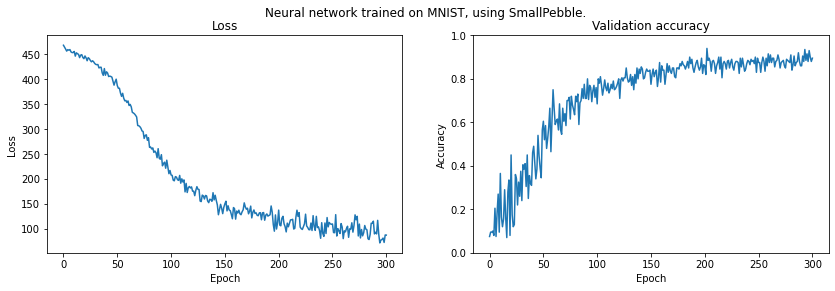

In [4]:
NUM_EPOCHS = 300
BATCH_SIZE = 200

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_EPOCHS):
    if i > NUM_EPOCHS: break
    
    X_in.assign_value(sp.Variable(xbatch))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()  # run the graph
    if np.isnan(loss_val.array):
        print("loss is nan, aborting.")
        break
    loss_vals.append(loss_val.array)
        
    # Compute gradients, and carry out learning step.
    gradients = sp.get_gradients(loss_val)
    sp.sgd_step(learnables, gradients, 3e-4)
        
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('Neural network trained on MNIST, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

## Training a convolutional neural network on MNIST

Make a function that creates trainable convolutional layers:

In [5]:
def convlayer(height, width, depth, n_kernels, strides=[1,1]):
    # Initialise kernels:
    sigma = np.sqrt(6 / (height*width*depth+height*width*n_kernels))
    kernels_init = sigma*(np.random.random([height, width, depth, n_kernels]) - .5)
    # Wrap with sp.Variable, so we can compute gradients:
    kernels = sp.Variable(kernels_init)
    # Flag as learnable, so we can extract from the model to train:
    kernels = sp.learnable(kernels)
    # Curry, to set `strides`:
    func = lambda images, kernels: sp.conv2d(images, kernels, strides=strides, padding='SAME')
    # Curry, to use the kernels created here:
    return lambda images: sp.Lazy(func)(images, kernels)

Define a model.

In [6]:
X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = convlayer(height=3, width=3, depth=1, n_kernels=16)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.Lazy(lambda x: sp.reshape(x, [-1, 14*14*16]))(h)
h = sp.linearlayer(14*14*16, 64)(h)
h = sp.Lazy(sp.leaky_relu)(h)

h = sp.linearlayer(64, 10)(h)
y_pred = sp.Lazy(sp.softmax)(h)
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

# Check we get the dimensions we expected.
X_in.assign_value(sp.Variable(X_train[0:3,:].reshape([-1,28,28,1])))
y_true.assign_value(y_train[0])
h.run().array.shape

(3, 10)

301it [03:35,  1.40it/s]                         


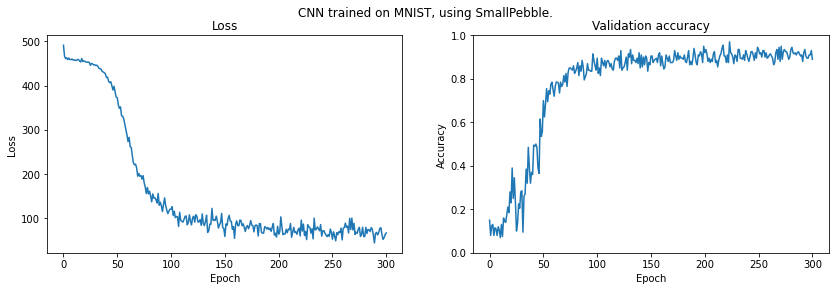

In [7]:
NUM_EPOCHS = 300
BATCH_SIZE = 200

eval_batch = sp.batch(X_eval.reshape([-1,28,28,1]), y_eval, BATCH_SIZE)

for i, (xbatch, ybatch) in tqdm(
    enumerate(sp.batch(X.reshape([-1,28,28,1]), y, BATCH_SIZE)), total=NUM_EPOCHS):
    if i > NUM_EPOCHS: break
    
    X_in.assign_value(sp.Variable(xbatch))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()
    if np.isnan(loss_val.array):
        print("Aborting, loss is nan.")
        break
    loss_vals.append(loss_val.array)
        
    # Compute gradients, and carry out learning step.
    gradients = sp.get_gradients(loss_val)
    sp.sgd_step(learnables, gradients, 3e-4)
        
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('CNN trained on MNIST, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

## Training a CNN on CIFAR

Load the dataset.

In [8]:
X_train, y_train, _, _ = load_data('cifar')
X_train = X_train/255

# Seperate out some data for validation.
X = X_train[:45_000, ...]
y = y_train[:45_000]
X_eval = X_train[45_000:50_000, ...]
y_eval = y_train[45_000:50_000]

Plot, to check it's the right data.

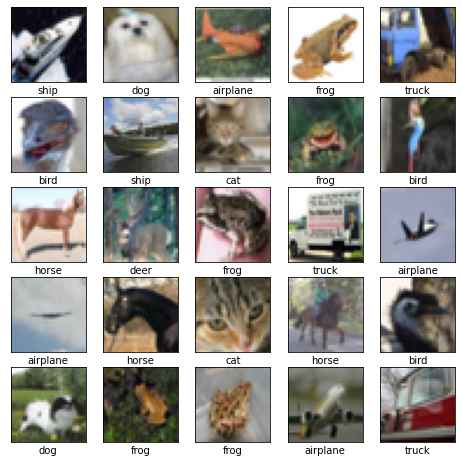

In [9]:
# This code is from: https://www.tensorflow.org/tutorials/images/cnn

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:].reshape(32,32,3), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.show()

Define the model. Due to my lack of ram, it is kept relatively small.

In [10]:
X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = convlayer(height=3, width=3, depth=3, n_kernels=16)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = convlayer(height=3, width=3, depth=16, n_kernels=32)(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.Lazy(lambda x: sp.reshape(x, [-1, 8*8*32]))(h)
h = sp.linearlayer(8*8*32, 64)(h)
h = sp.Lazy(sp.leaky_relu)(h)

h = sp.linearlayer(64, 10)(h)
h = sp.Lazy(sp.softmax)(h)

y_pred = h
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

# Check we get the expected dimensions
X_in.assign_value(sp.Variable(X[0:3, :].reshape([-1, 32, 32, 3])))
h.run().shape

(3, 10)

Train the model.

3001it [25:16,  1.98it/s]                            


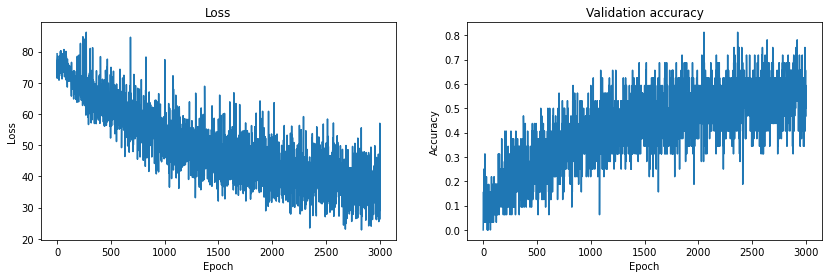

In [11]:
NUM_EPOCHS = 3000
BATCH_SIZE = 32

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_EPOCHS):
    if i > NUM_EPOCHS: break
       
    xbatch_images = xbatch.reshape([-1, 32, 32, 3])
    X_in.assign_value(sp.Variable(xbatch_images))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()
    if np.isnan(loss_val.array):
        print("Aborting, loss is nan.")
        break
    loss_vals.append(loss_val.array)
    
    # Compute gradients, and carry out learning step.
    gradients = sp.get_gradients(loss_val)  
    sp.sgd_step(learnables, gradients, 3e-3)
          
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch.reshape([-1, 32, 32, 3])))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(validation_acc)
plt.show()

And we see some improvement, despite the model's small size. 

---

# Brief guide to using SmallPebble

SmallPebble provides the following building blocks to make models with:

- `sp.Variable`
- SmallPebble operations, such as `sp.add`, `sp.mul`, etc.
- `sp.get_gradients`
- `sp.Lazy`
- `sp.Placeholder` (this is really just `sp.Lazy` on the identity function)
- `sp.learnable`
- `sp.get_learnables`

The following examples show how these are used.

## sp.Variable & sp.get_gradients 

With SmallPebble, you can:

- Wrap NumPy arrays in `sp.Variable`
- Apply SmallPebble operations (e.g. `sp.matmul`, `sp.add`, etc.)
- Compute gradients with `sp.get_gradients`

In [12]:
a = sp.Variable(np.random.random([2, 2]))
b = sp.Variable(np.random.random([2, 2]))
c = sp.Variable(np.random.random([2]))
y = sp.mul(a, b) + c
print('y.array:\n', y.array)

gradients = sp.get_gradients(y)
grad_a = gradients[a]
grad_b = gradients[b]
grad_c = gradients[c]
print('grad_a:\n', grad_a)
print('grad_b:\n', grad_b)
print('grad_c:\n', grad_c)

y.array:
 [[0.50222439 0.67745659]
 [0.68666171 0.58330707]]
grad_a:
 [[0.56436821 0.2581522 ]
 [0.89043144 0.25750461]]
grad_b:
 [[0.11665152 0.85303194]
 [0.28106794 0.48955456]]
grad_c:
 [2. 2.]


Note that `y` is computed straight away, i.e. the (forward) computation happens immediately.

Also note that `y` is a sp.Variable and we could continue to carry out SmallPebble operations on it.

## sp.Lazy & sp.Placeholder

Lazy graphs are constructed using `sp.Lazy` and `sp.Placeholder`. 

In [13]:
lazy_node = sp.Lazy(lambda a, b: a + b)(1, 2)
print(lazy_node)
print(lazy_node.run())

3


In [14]:
a = sp.Lazy(lambda a: a)(2)
y = sp.Lazy(lambda a, b, c: a * b + c)(a, 3, 4)
print(y)
print(y.run())

10


Forward computation does not happen immediately - only when .run() is called.

In [15]:
a = sp.Placeholder()
b = sp.Variable(np.random.random([2, 2]))
y = sp.Lazy(sp.matmul)(a, b)

a.assign_value(sp.Variable(np.array([[1,2], [3,4]])))

result = y.run()
print('result.array:\n', result.array)

result.array:
 [[1.01817665 2.54693119]
 [2.42244218 5.69810698]]


You can use .run() as many times as you like. 

Let's change the placeholder value and re-run the graph:

In [16]:
a.assign_value(sp.Variable(np.array([[10,20], [30,40]])))
result = y.run()
print('result.array:\n', result.array)

result.array:
 [[10.18176654 25.46931189]
 [24.22442177 56.98106985]]


Finally, let's compute gradients:

In [17]:
gradients = sp.get_gradients(result)

Note that `sp.get_gradients` is called on `result`, 
which is a `sp.Variable`, 
not on `y`, which is a `sp.Lazy` instance.

## sp.learnable & sp.get_learnables
Use `sp.learnable` to flag parameters as learnable, 
allowing them to be extracted from a lazy graph with `sp.get_learnables`.

This enables the workflow of building a model, while flagging parameters as learnable, and then extracting all the parameters in one go at the end.


In [18]:
a = sp.Placeholder()
b = sp.learnable(sp.Variable(np.random.random([2, 1])))
y = sp.Lazy(sp.matmul)(a, b)
y = sp.Lazy(sp.add)(y, sp.learnable(sp.Variable(np.array([5]))))

learnables = sp.get_learnables(y)

for learnable in learnables:
    print(learnable)

## Switching between NumPy and CuPy

We can dynamically switch between NumPy and CuPy:

```python
import cupy
import numpy
import smallpebble as sp

# Switch to CuPy.
sp.array_library = cupy

# And back to NumPy again:
sp.array_library = numpy
```